# Enrichment analysis of CNVs in schizophrenia

## Steps
1. Load CNV data and reference gene database, and drop identical CNVs and genes.
  * FIXME: boundary of genes are yet to be polished
2. Count the number of CNVs overlapping with each gene.
3. Perform Fisher Exact tests for each gene which is overlapped with CNVs in deletion and duplication.
4. Draw barplots for deletion and duplication.

In [1]:
import pandas as pd
from pandasql import sqldf
from fisher import pvalue
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# for the plot to be showed in Jupyter notebook
%matplotlib inline

## Load CNV and drop duplicates
CNV bed includes four separate datasets, deletion cases, deletion controls, duplication cases and duplication controls. The sample sizes for the four datasets are 1374, 1278, 2228 and 1873, respectively. Every line in each dataset represents a CNV (chromosome, start and end position). Similar start and end positions exit. Some of them are only different by hundreds to thousands of SNPs.

Import CNV.bed file first, divide into four datasets. Each dataset includes 22 chromosome and CNV start/end positions on each chromosome. Then, sort start/end position by ascending order. The CNV.bed file does not include sex chromosome.

In [2]:
filename = "data/ISC-r1.CNV.bed"
cnvbed = {}
dataset = None
for line in open(filename).readlines():
    if not line.startswith("chr"):
        dataset = line.strip().split()[1].lstrip("name=")
        cnvbed[dataset] = {}
        continue
    line = line.strip().split()
    if not line[0] in cnvbed[dataset]:
        cnvbed[dataset][line[0]] = []
    cnvbed[dataset][line[0]].append((int(line[1]),int(line[2])))
    
for dataset in cnvbed.keys():
    for chrom in cnvbed[dataset]:
        cnvbed[dataset][chrom].sort()

Use pandas to transfer dictionaries from last step to a DataFrame, which contains four parts, cases and controls for deletion and duplication, then drop cuplicates if CNVs share identical chromosome, start and end position.

In [3]:
cnvbed_df = {}
for dataset in cnvbed.keys():
    cnvbed_df[dataset] = {"chrom":[], "cnv_start":[], "cnv_end":[]}
    for chrom in cnvbed[dataset]:
        start, end = tuple(zip(*cnvbed[dataset][chrom]))
        cnvbed_df[dataset]["chrom"].extend([chrom] * len(start))
        cnvbed_df[dataset]["cnv_start"] += list(start)
        cnvbed_df[dataset]["cnv_end"] += list(end)
    cnvbed_df[dataset] = pd.DataFrame.from_dict(cnvbed_df[dataset]).drop_duplicates(
                                            subset=("chrom", "cnv_start", "cnv_end"))
#print (cnvbed_df)

## Load reference gene database and drop duplicates
Import reference transcripts and their chromosome, start and end position as a table using pandas.

Use sqldf to query DataFrame. Combine gene by dropping duplicates if they share identical chromosome, start and end position.

In [4]:
ref_gene = pd.read_table("data/refGene.txt.gz", compression="gzip", sep="\t", 
                         header = None, usecols=(2,4,5,12), 
                         names = ["chrom", "tx_start", "tx_end", "gene_name"])

gene_df = ref_gene.drop_duplicates(subset=("chrom", "tx_start", "tx_end"))
gene_df = gene_df.rename(columns={"tx_start": "gene_start", "tx_end": "gene_end"})
print (gene_df[:10])

    chrom  gene_start   gene_end     gene_name
0    chr1       11873      14409       DDX11L1
1    chr1       14361      29370        WASH7P
2    chrX     2527305    2575270        CD99P1
3    chrY     2477305    2506370        CD99P1
4    chr5   180650262  180662808        TRIM41
5   chr12    51236700   51281663      TMPRSS12
6    chr1      134772     140566     LOC729737
7    chr1      323891     328581  LOC100132287
10   chr2    71680752   71913893          DYSF
11  chr19    54573200   54584634         TARM1


## Calculate number of CNVs per gene
Figure out the number of CNVs overlapped in each gene according to their start/end positions.
* If the start and/or end postion for a CNV locate between a gene, it is said that CNV and gene overlap. Each line represents a CNV. However, same CNV may overlap with more than one gene, and one gene may contain more than one CNV.

|   |  chr |  start |  end |  gene |
|---|---|---|---|---|
|1|     chr11|    1774671 |   1945240 |         CTSD|
|2|     chr11|    1774671 |   1945240 |        TNNT3|
|3|     chr11|    4077830 |   4264576 |        STIM1|
|4|     chr11|    4077830 |   4303386 |        STIM1|
|5|     chr11|    4081373 |   4232710 |        STIM1|
|6|     chr11|    4081373 |   4302348 |        STIM1|

* Count the number of CNVs overlap with each gene in cases vs controls.

In [5]:
cnv_in_gene = {}
cnv_counts = {}
for name, value in cnvbed_df.items():
    query = """
    SELECT cnv.chrom, cnv.cnv_start, cnv.cnv_end, gene.gene_name
    FROM value cnv LEFT JOIN gene_df gene
    WHERE cnv.chrom == gene.chrom 
    AND (
    (cnv.cnv_start >= gene.gene_start AND cnv.cnv_start <= gene.gene_end)
    OR
    (cnv.cnv_end >= gene.gene_start AND cnv.cnv_end <= gene.gene_end)
    OR
    (cnv.cnv_start <= gene.gene_start AND cnv.cnv_end >= gene.gene_end)
    )
    """
    cnv_in_gene[name] = value = sqldf(query).drop_duplicates(
        subset=("chrom", "cnv_start", "cnv_end", "gene_name"))
    query = """
    SELECT chrom, gene_name, count(gene_name), cnv_start, cnv_end
    FROM value
    GROUP BY gene_name, chrom
    ORDER BY count(gene_name) DESC
    """
    cnv_counts[name] = sqldf(query)

CNV annotated by gene names:

In [6]:
print (cnv_in_gene["delCases"][:10])

   chrom  cnv_start   cnv_end  gene_name
0   chr6    1795443   2004110       GMDS
2   chr6    5190273   5339000  LYRM4-AS1
3   chr6    5190273   5339000      LYRM4
7   chr6    5190273   5339000      FARS2
9   chr6    5192635   5339000  LYRM4-AS1
10  chr6    5192635   5339000      LYRM4
14  chr6    5192635   5339000      FARS2
16  chr6   20862098  21032454     CDKAL1
17  chr6   21995255  22107280     CASC15
18  chr6   38010229  38176605     ZFAND3


Number of CNVs per gene:

In [7]:
print (cnv_counts["delCases"][:10])

  chrom  gene_name  count(gene_name)  cnv_start    cnv_end
0  chr7     IMMP2L                26  110799758  110973658
1  chr7      LRRN3                21  110743162  110882041
2  chr1     NBPF20                18  145306080  146059433
3  chr7     ZNF107                18   64140194   64340502
4  chr7     ZNF138                18   64140194   64340502
5  chr7    MIR6839                17   64135315   64362129
6  chr1      NBPF9                16  145306080  146059433
7  chr7     ZNF273                16   64095790   64532287
8  chr9  ANKRD20A2                15   41889553   43265950
9  chr9  ANKRD20A3                15   41889553   43265950


### Question
Some genes may spread widely as the two tables showed below, so the CNV overlapping may be complex.

In [8]:
query = """
select gene_name, chrom, tx_start, tx_end
from ref_gene 
where gene_name = "LOC101928381"
"""
print (sqldf(query))

query = """
select gene_name, chrom, tx_start, tx_end
from ref_gene 
where gene_name = "FAM72C"
"""
print (sqldf(query))

      gene_name chrom  tx_start    tx_end
0  LOC101928381  chr9  42771707  42782614
1  LOC101928381  chr9  66922966  66933829
2  LOC101928381  chr9  69746916  69757784
3  LOC101928381  chr9  70364017  70374924
  gene_name chrom   tx_start     tx_end
0    FAM72C  chr1  143896524  143913160
1    FAM72C  chr1  206138439  206155074
2    FAM72C  chr1  143896524  143913160
3    FAM72C  chr1  143896524  143913160
4    FAM72C  chr1  143896524  143914673
5    FAM72C  chr1  143896524  143914673
6    FAM72C  chr1  143904508  143913160


## Enrichment analyses (Fisher Exact test)
* Combine deletion cases and controls to generate 2 by 2 table for Fisher exact test.

In [9]:
delCases = cnv_counts["delCases"]
delControls = cnv_counts["delControls"]
del_table = pd.merge(delCases, delControls, how = "outer", on = ["chrom", "gene_name"])
del_table["count(gene_name)_x"].fillna(0, inplace=True)
del_table["count(gene_name)_y"].fillna(0, inplace=True)
n_delCases = sum(cnv_counts["delCases"]["count(gene_name)"])
n_delCtrls = sum(cnv_counts["delControls"]["count(gene_name)"])
del_table = del_table.rename(columns={"count(gene_name)_x": "n_delcase_gene", 
                                      "count(gene_name)_y": "n_delctrl_gene"})
del_table["n_delcase_nogene"] = n_delCases - del_table["n_delcase_gene"]
del_table["n_delctrl_nogene"] = n_delCtrls - del_table["n_delctrl_gene"]
del_table = del_table[["gene_name", "n_delcase_gene", "n_delctrl_gene", "n_delcase_nogene", "n_delctrl_nogene"]]

* Combine duplication cases and controls to generate 2 by 2 table for Fisher exact test.

In [10]:
dupCases = cnv_counts["dupCases"]
dupControls = cnv_counts["dupControls"]
dup_table = pd.merge(dupCases, dupControls, how = "outer", on = ["chrom", "gene_name"])
dup_table["count(gene_name)_x"].fillna(0, inplace=True)
dup_table["count(gene_name)_y"].fillna(0, inplace=True)
n_dupCases = sum(cnv_counts["dupCases"]["count(gene_name)"])
n_dupCtrls = sum(cnv_counts["dupControls"]["count(gene_name)"])
dup_table = dup_table.rename(columns={"count(gene_name)_x": "n_dupcase_gene", 
                                      "count(gene_name)_y": "n_dupctrl_gene"})
dup_table["n_dupcase_nogene"] = n_dupCases - dup_table["n_dupcase_gene"]
dup_table["n_dupctrl_nogene"] = n_dupCtrls - dup_table["n_dupctrl_gene"]
dup_table = dup_table[["gene_name", "n_dupcase_gene", "n_dupctrl_gene", "n_dupcase_nogene", "n_dupctrl_nogene"]]

* Calculate Fisher Exact test results, two-sided and right-sided, for deletion cases and controls.

In [11]:
res_del = [(pvalue(row["n_delcase_gene"], row["n_delctrl_gene"], 
               row["n_delcase_nogene"], row["n_delctrl_nogene"]),
        row["gene_name"]) for idx, row in del_table.iterrows()]

res_del = sorted(res_del, reverse=True, key = lambda x: -np.log10(x[0].two_tail))
top_logp_2side_del = [-np.log10(x[0].two_tail) for x in res_del[:100]]
top_gene_list_del = [x[1] for x in res_del[:100]]

* Calculate Fisher Exact test results, two-sided and right-sided, for duplication cases and controls.

In [12]:
res_dup = [(pvalue(row["n_dupcase_gene"], row["n_dupctrl_gene"], 
               row["n_dupcase_nogene"], row["n_dupctrl_nogene"]),
        row["gene_name"]) for idx, row in dup_table.iterrows()]

res_dup = sorted(res_dup, reverse=True, key = lambda x: -np.log10(x[0].two_tail))
top_logp_2side_dup = [-np.log10(x[0].two_tail) for x in res_dup[:100]]
top_gene_list_dup = [x[1] for x in res_dup[:100]]

## Visualize enrichment analyses
* Draw barplot of -log10(p_2sided) for deletion.

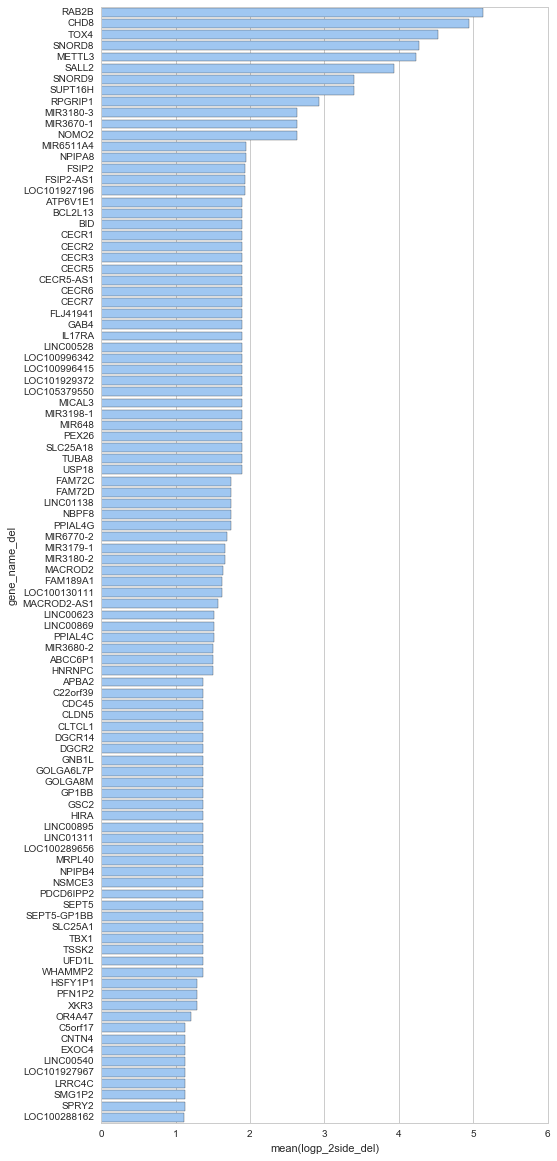

In [13]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 20))
p_df_del = pd.DataFrame({"logp_2side_del": top_logp_2side_del, "gene_name_del": top_gene_list_del})
plot_del = sns.barplot(x="logp_2side_del", y="gene_name_del", data=p_df_del, label="log pvalue 2-sided", color="b")

* Draw barplot of -log10(p_2sided) for duplication.

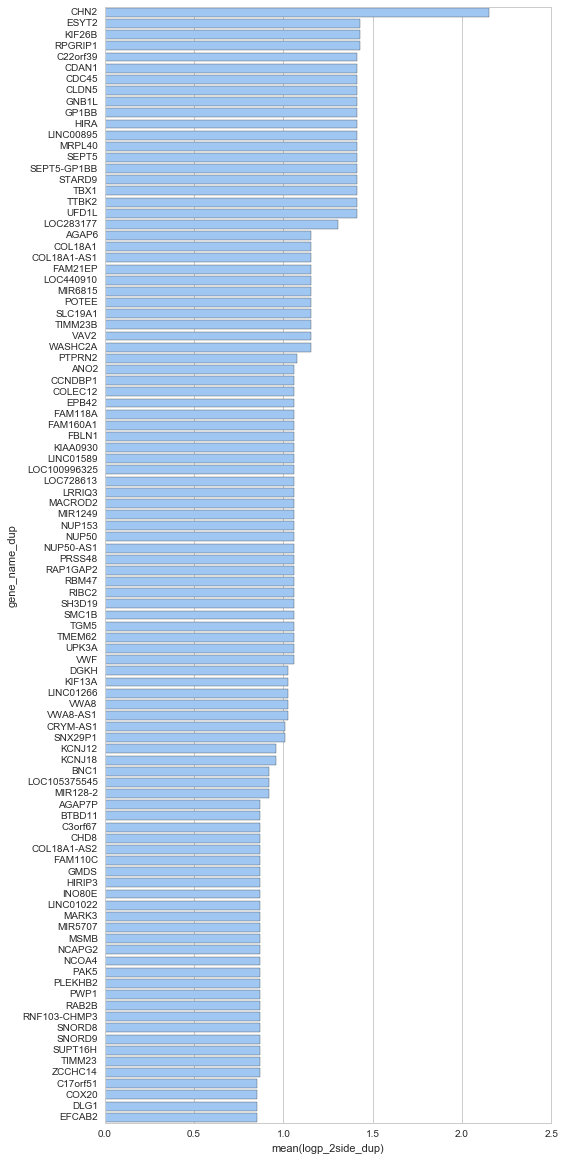

In [14]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 20))
p_df_dup = pd.DataFrame({"logp_2side_dup": top_logp_2side_dup, "gene_name_dup": top_gene_list_dup})
plot_dup = sns.barplot(x="logp_2side_dup", y="gene_name_dup", data=p_df_dup, label="log pvalue 2-sided", color="b")

## Reference
* The website for seaborn is available at [http://seaborn.pydata.org/examples/horizontal_barplot.html](http://seaborn.pydata.org/examples/horizontal_barplot.html).

* Use fast Fisher's Exact test at [https://pypi.python.org/pypi/fisher/](https://pypi.python.org/pypi/fisher/).

* Use pandas and [pandasql](https://pypi.python.org/pypi/pandasql) to transfer dictionary to DataFrame and to query pandas DataFrames using SQL syntax.